In [1]:
# Cell 1: Import all required libraries
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("✅ All libraries imported successfully")
print(f"📅 Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All libraries imported successfully
📅 Current date: 2025-08-10 23:15:48


In [2]:
# Cell 2: Connect to MT5
def setup_mt5():
    if not mt5.initialize():
        print("❌ MT5 initialization failed")
        return False
    print("✅ MT5 connected successfully")
    return True

# Test connection
mt5_connected = setup_mt5()
if mt5_connected:
    print(f"📊 MT5 Version: {mt5.version()}")


✅ MT5 connected successfully
📊 MT5 Version: (500, 5200, '1 Aug 2025')


In [3]:
# Cell 3: Collect EURUSD 15M data
def collect_eurusd_data(total_candles=2000):
    """Collect EURUSD 15M data for training"""
    rates = mt5.copy_rates_from_pos("EURUSD", mt5.TIMEFRAME_M15, 0, total_candles)
    
    if rates is None:
        print("❌ No data received")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df[['time', 'open', 'high', 'low', 'close', 'tick_volume']].copy()
    
    return df

# Collect data
print("📡 Collecting EURUSD 15M data...")
eurusd_data = collect_eurusd_data(2000)

if eurusd_data is not None:
    print(f"✅ Collected {len(eurusd_data)} candles")
    print(f"📅 Date range: {eurusd_data['time'].min()} to {eurusd_data['time'].max()}")
    
    # Split train/test
    train_data = eurusd_data.iloc[:1000].copy()
    test_data = eurusd_data.iloc[1000:].copy()
    
    print(f"📊 Training: {len(train_data)} | Testing: {len(test_data)} candles")
    
    # Show sample data
    display(train_data.head(3))
else:
    print("❌ Data collection failed")


📡 Collecting EURUSD 15M data...
✅ Collected 2000 candles
📅 Date range: 2025-07-11 01:00:00 to 2025-08-08 20:45:00
📊 Training: 1000 | Testing: 1000 candles


,time,open,high,low,close,tick_volume
0,2025-07-11 01:00:00,1.16749,1.16774,1.16688,1.16736,873
1,2025-07-11 01:15:00,1.16736,1.16797,1.16731,1.16781,796
2,2025-07-11 01:30:00,1.16782,1.16860,1.16776,1.16830,754


In [4]:
# Cell 4: Pin Bar Detection
def detect_pin_bars(df, min_nose_ratio=0.6, max_body_ratio=0.3):
    """Detect pin bar patterns with flexible criteria"""
    df = df.copy()
    
    # Calculate candle components
    df['body_size'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - np.maximum(df['open'], df['close'])
    df['lower_shadow'] = np.minimum(df['open'], df['close']) - df['low']
    df['total_range'] = df['high'] - df['low']
    df['total_range'] = df['total_range'].replace(0, 0.0001)
    
    # Calculate ratios
    df['body_ratio'] = df['body_size'] / df['total_range']
    df['upper_nose_ratio'] = df['upper_shadow'] / df['total_range']
    df['lower_nose_ratio'] = df['lower_shadow'] / df['total_range']
    
    # Pin bar detection
    bullish_conditions = (
        (df['lower_nose_ratio'] >= min_nose_ratio) &
        (df['body_ratio'] <= max_body_ratio) &
        (df['upper_shadow'] <= df['body_size'])
    )
    
    bearish_conditions = (
        (df['upper_nose_ratio'] >= min_nose_ratio) &
        (df['body_ratio'] <= max_body_ratio) &
        (df['lower_shadow'] <= df['body_size'])
    )
    
    # Create columns
    df['bullish_pin_bar'] = bullish_conditions.astype(int)
    df['bearish_pin_bar'] = bearish_conditions.astype(int)
    df['any_pin_bar'] = (bullish_conditions | bearish_conditions).astype(int)
    
    # Strength scoring
    df['pin_bar_strength'] = 0
    df['range_rolling_mean'] = df['total_range'].rolling(10, min_periods=1).mean()
    
    # Bullish pin strength
    bullish_mask = df['bullish_pin_bar'] == 1
    if bullish_mask.any():
        df.loc[bullish_mask, 'pin_bar_strength'] = (
            (df.loc[bullish_mask, 'lower_nose_ratio'] >= 0.7).astype(int) +
            (df.loc[bullish_mask, 'body_ratio'] <= 0.2).astype(int) +
            (df.loc[bullish_mask, 'total_range'] > df.loc[bullish_mask, 'range_rolling_mean']).astype(int)
        )
    
    # Bearish pin strength
    bearish_mask = df['bearish_pin_bar'] == 1
    if bearish_mask.any():
        df.loc[bearish_mask, 'pin_bar_strength'] = (
            (df.loc[bearish_mask, 'upper_nose_ratio'] >= 0.7).astype(int) +
            (df.loc[bearish_mask, 'body_ratio'] <= 0.2).astype(int) +
            (df.loc[bearish_mask, 'total_range'] > df.loc[bearish_mask, 'range_rolling_mean']).astype(int)
        )
    
    df.drop('range_rolling_mean', axis=1, inplace=True)
    return df

print("✅ Pin bar detection function ready")


✅ Pin bar detection function ready


In [5]:
# Cell 5: Apply pin bar detection to training data
print("🎯 Detecting pin bars in training data...")
processed_train_data = detect_pin_bars(train_data)

# Show results
total_pins = processed_train_data['any_pin_bar'].sum()
bullish_pins = processed_train_data['bullish_pin_bar'].sum()
bearish_pins = processed_train_data['bearish_pin_bar'].sum()

print(f"📊 Pin Bar Detection Results:")
print(f"   Total Pin Bars: {total_pins}")
print(f"   Bullish: {bullish_pins} | Bearish: {bearish_pins}")
print(f"   Frequency: {total_pins/len(processed_train_data)*100:.1f}%")

# Show strength distribution
if total_pins > 0:
    strength_counts = processed_train_data[processed_train_data['any_pin_bar']==1]['pin_bar_strength'].value_counts().sort_index()
    print(f"\n🎯 Pin Bar Strength Distribution:")
    for strength, count in strength_counts.items():
        print(f"   Strength {strength}: {count} pin bars")

# Display sample pin bars
pin_bars_sample = processed_train_data[processed_train_data['any_pin_bar']==1][
    ['time', 'open', 'high', 'low', 'close', 'bullish_pin_bar', 'bearish_pin_bar', 'pin_bar_strength']
].head(5)

print(f"\n📋 Sample Pin Bars:")
display(pin_bars_sample)


🎯 Detecting pin bars in training data...
📊 Pin Bar Detection Results:
   Total Pin Bars: 67
   Bullish: 41 | Bearish: 26
   Frequency: 6.7%

🎯 Pin Bar Strength Distribution:
   Strength 0: 17 pin bars
   Strength 1: 25 pin bars
   Strength 2: 23 pin bars
   Strength 3: 2 pin bars

📋 Sample Pin Bars:


,time,open,high,low,close,bullish_pin_bar,bearish_pin_bar,pin_bar_strength
14,2025-07-11 04:30:00,1.16702,1.16747,1.16694,1.16715,0,1,0
20,2025-07-11 06:00:00,1.16782,1.16782,1.16705,1.16761,1,0,2
53,2025-07-11 14:15:00,1.16842,1.16842,1.16741,1.16813,1,0,1
82,2025-07-13 21:30:00,1.16673,1.16703,1.16611,1.16697,1,0,1
109,2025-07-14 04:15:00,1.16789,1.16793,1.16758,1.16784,1,0,2


📊 Creating candlestick chart...


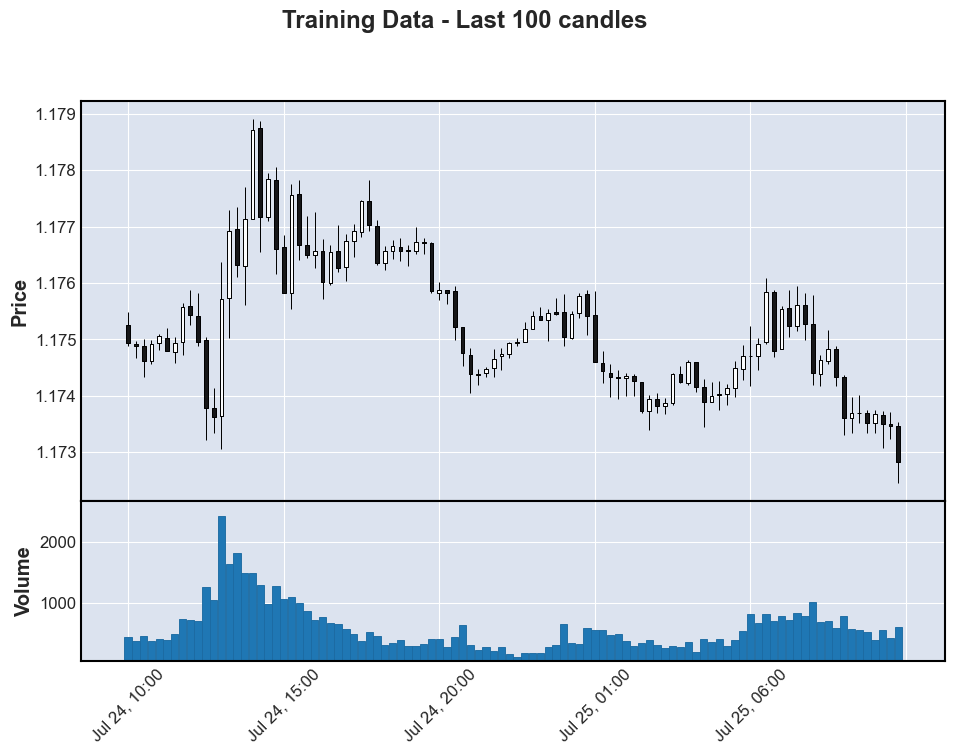

In [6]:
# Cell 6: Create simple chart visualization
def plot_simple_candlestick(df, candles=100, title="EURUSD 15M"):
    """Simple candlestick chart using matplotlib"""
    
    # Get last N candles
    chart_data = df.tail(candles).copy()
    chart_data.set_index('time', inplace=True)
    
    # Rename columns for mplfinance
    chart_data.rename(columns={
        'open': 'Open', 'high': 'High', 
        'low': 'Low', 'close': 'Close', 
        'tick_volume': 'Volume'
    }, inplace=True)
    
    # Create chart
    mpf.plot(chart_data[['Open', 'High', 'Low', 'Close', 'Volume']], 
             type='candle',
             volume=True,
             title=f"{title} - Last {candles} candles",
             figsize=(12, 8))

# Plot training data
print("📊 Creating candlestick chart...")
plot_simple_candlestick(processed_train_data, candles=100, title="Training Data")


In [7]:
# Cell 7: Create success targets for pin bars
def create_success_targets(df, lookahead_candles=3, pip_target=10):
    """Create success labels for pin bar trades"""
    df = df.copy()
    
    pip_value = 0.0001  # EURUSD pip value
    pip_target_price = pip_target * pip_value
    
    # Initialize success columns
    df['bullish_success'] = 0
    df['bearish_success'] = 0
    df['any_success'] = 0
    
    # Check success for each pin bar
    for i in range(len(df) - lookahead_candles):
        current_close = df.iloc[i]['close']
        
        # Get future price range
        future_slice = df.iloc[i+1:i+1+lookahead_candles]
        future_high = future_slice['high'].max()
        future_low = future_slice['low'].min()
        
        # Check bullish pin bar success
        if df.iloc[i]['bullish_pin_bar'] == 1:
            if future_high >= (current_close + pip_target_price):
                df.iloc[i, df.columns.get_loc('bullish_success')] = 1
                df.iloc[i, df.columns.get_loc('any_success')] = 1
        
        # Check bearish pin bar success
        if df.iloc[i]['bearish_pin_bar'] == 1:
            if future_low <= (current_close - pip_target_price):
                df.iloc[i, df.columns.get_loc('bearish_success')] = 1
                df.iloc[i, df.columns.get_loc('any_success')] = 1
    
    return df

# Apply success targets
print("🎯 Creating success targets (10 pips, 3 candles ahead)...")
processed_train_data = create_success_targets(processed_train_data)

# Analyze success rates
pin_bars = processed_train_data[processed_train_data['any_pin_bar'] == 1]
successful_pins = pin_bars[pin_bars['any_success'] == 1]
success_rate = len(successful_pins) / len(pin_bars) * 100 if len(pin_bars) > 0 else 0

print(f"📈 Pin Bar Success Analysis:")
print(f"   Total pin bars: {len(pin_bars)}")
print(f"   Successful pin bars: {len(successful_pins)}")
print(f"   Success rate: {success_rate:.1f}%")

# Show success by strength
print(f"\n📊 Success Rate by Strength:")
for strength in range(4):
    strength_pins = pin_bars[pin_bars['pin_bar_strength'] == strength]
    if len(strength_pins) > 0:
        strength_successes = strength_pins['any_success'].sum()
        strength_rate = strength_successes / len(strength_pins) * 100
        print(f"   Strength {strength}: {strength_successes}/{len(strength_pins)} = {strength_rate:.1f}%")


🎯 Creating success targets (10 pips, 3 candles ahead)...
📈 Pin Bar Success Analysis:
   Total pin bars: 67
   Successful pin bars: 15
   Success rate: 22.4%

📊 Success Rate by Strength:
   Strength 0: 2/17 = 11.8%
   Strength 1: 7/25 = 28.0%
   Strength 2: 5/23 = 21.7%
   Strength 3: 1/2 = 50.0%


In [8]:
# Fix: Define recent_pins if not available
if 'recent_pins' not in locals():
    print("🔧 Defining recent_pins variable...")
    if 'processed_train_data' in locals():
        recent_pins = processed_train_data[processed_train_data['any_pin_bar'] == 1].tail(10)
        print(f"✅ Found {len(recent_pins)} recent pin bars")
    else:
        print("❌ processed_train_data not available either")
        print("🔄 Need to run previous cells first")

# Fixed Function: Prepare features for predictions (handles NaN values)
def prepare_prediction_features(df):
    """
    Prepare features for prediction - handles small datasets and NaN values
    """
    df = df.copy()
    
    # Basic features (should already exist)
    feature_columns = ['body_ratio', 'upper_nose_ratio', 'lower_nose_ratio']
    feature_columns.extend(['bullish_pin_bar', 'bearish_pin_bar', 'pin_bar_strength'])
    
    # Technical indicators - use backward fill for small datasets
    df['sma_5'] = df['close'].rolling(5, min_periods=1).mean()
    df['sma_20'] = df['close'].rolling(20, min_periods=1).mean()
    df['price_vs_sma5'] = (df['close'] - df['sma_5']) / df['close']
    df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['close']
    feature_columns.extend(['price_vs_sma5', 'price_vs_sma20'])
    
    # Volume features - use min_periods
    df['volume_ma'] = df['tick_volume'].rolling(10, min_periods=1).mean()
    df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
    feature_columns.extend(['volume_ratio'])
    
    # Range features - use min_periods
    df['atr'] = df['total_range'].rolling(14, min_periods=1).mean()
    df['range_vs_atr'] = df['total_range'] / df['atr']
    feature_columns.extend(['range_vs_atr'])
    
    # Time features
    df['hour'] = df['time'].dt.hour
    feature_columns.extend(['hour'])
    
    # Handle any remaining NaN values by forward/backward fill
    for col in feature_columns:
        if col in df.columns:
            df[col] = df[col].fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    # Don't filter for pin bars since input should already be pin bars only
    X = df[feature_columns].values
    
    print(f"✅ Prediction features prepared: {X.shape}")
    return X, feature_columns

# Test the fixed function
print("🧪 Testing fixed feature preparation...")

# Check if recent_pins is now available
if 'recent_pins' in locals() and len(recent_pins) > 0:
    X_recent_fixed, feature_names_fixed = prepare_prediction_features(recent_pins)
    
    if X_recent_fixed is not None and len(X_recent_fixed) > 0:
        print("✅ Feature preparation successful!")
        
        # Make predictions with the trained model
        if 'trained_model' in locals() and trained_model is not None:
            predictions = trained_model.predict(X_recent_fixed)
            probabilities = trained_model.predict_proba(X_recent_fixed)[:, 1]
            
            print(f"\n🎯 SUCCESSFUL PREDICTIONS:")
            print("="*50)
            
            for i, (idx, row) in enumerate(recent_pins.iterrows()):
                if i < len(probabilities):
                    pin_type = "Bullish" if row['bullish_pin_bar'] else "Bearish"
                    strength = row['pin_bar_strength']
                    prob = probabilities[i]
                    
                    print(f"📅 {row['time'].strftime('%Y-%m-%d %H:%M')}")
                    print(f"   🎯 {pin_type} Pin Bar (Strength: {strength})")
                    print(f"   🤖 Success Probability: {prob*100:.1f}%")
                    print(f"   💡 Recommendation: {'✅ TRADE' if prob > 0.6 else '❌ SKIP'}")
                    print("-" * 30)
            
            print("🎉 PREDICTIONS COMPLETE!")
        else:
            print("❌ No trained model available")
    else:
        print("❌ Feature preparation still failed")
else:
    print("❌ No recent_pins data available")
    print("🔄 Please run the previous cells in sequence:")
    print("   1. Data collection cells")
    print("   2. Pin bar detection cells") 
    print("   3. Model training cells")



# Fixed Function: Prepare features for predictions (handles NaN values)
def prepare_prediction_features(df):
    """
    Prepare features for prediction - handles small datasets and NaN values
    """
    df = df.copy()
    
    # Basic features (should already exist)
    feature_columns = ['body_ratio', 'upper_nose_ratio', 'lower_nose_ratio']
    feature_columns.extend(['bullish_pin_bar', 'bearish_pin_bar', 'pin_bar_strength'])
    
    # Technical indicators - use backward fill for small datasets
    df['sma_5'] = df['close'].rolling(5, min_periods=1).mean()
    df['sma_20'] = df['close'].rolling(20, min_periods=1).mean()
    df['price_vs_sma5'] = (df['close'] - df['sma_5']) / df['close']
    df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['close']
    feature_columns.extend(['price_vs_sma5', 'price_vs_sma20'])
    
    # Volume features - use min_periods
    df['volume_ma'] = df['tick_volume'].rolling(10, min_periods=1).mean()
    df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
    feature_columns.extend(['volume_ratio'])
    
    # Range features - use min_periods
    df['atr'] = df['total_range'].rolling(14, min_periods=1).mean()
    df['range_vs_atr'] = df['total_range'] / df['atr']
    feature_columns.extend(['range_vs_atr'])
    
    # Time features
    df['hour'] = df['time'].dt.hour
    feature_columns.extend(['hour'])
    
    # Handle any remaining NaN values by forward/backward fill
    for col in feature_columns:
        if col in df.columns:
            df[col] = df[col].fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    # Don't filter for pin bars since input should already be pin bars only
    X = df[feature_columns].values
    
    print(f"✅ Prediction features prepared: {X.shape}")
    return X, feature_columns

# Test the fixed function
print("🧪 Testing fixed feature preparation...")
X_recent_fixed, feature_names_fixed = prepare_prediction_features(recent_pins)

if X_recent_fixed is not None and len(X_recent_fixed) > 0:
    print("✅ Feature preparation successful!")
    
    # Make predictions with the trained model
    if 'trained_model' in locals() and trained_model is not None:
        predictions = trained_model.predict(X_recent_fixed)
        probabilities = trained_model.predict_proba(X_recent_fixed)[:, 1]
        
        print(f"\n🎯 SUCCESSFUL PREDICTIONS:")
        print("="*50)
        
        for i, (idx, row) in enumerate(recent_pins.iterrows()):
            if i < len(probabilities):
                pin_type = "Bullish" if row['bullish_pin_bar'] else "Bearish"
                strength = row['pin_bar_strength']
                prob = probabilities[i]
                
                print(f"📅 {row['time'].strftime('%Y-%m-%d %H:%M')}")
                print(f"   🎯 {pin_type} Pin Bar (Strength: {strength})")
                print(f"   🤖 Success Probability: {prob*100:.1f}%")
                print(f"   💡 Recommendation: {'✅ TRADE' if prob > 0.6 else '❌ SKIP'}")
                print("-" * 30)
        
        print("🎉 PREDICTIONS COMPLETE!")
    else:
        print("❌ No trained model available")
else:
    print("❌ Feature preparation still failed")


🔧 Defining recent_pins variable...
✅ Found 10 recent pin bars
🧪 Testing fixed feature preparation...
✅ Prediction features prepared: (10, 11)
✅ Feature preparation successful!
❌ No trained model available
🧪 Testing fixed feature preparation...
✅ Prediction features prepared: (10, 11)
✅ Feature preparation successful!
❌ No trained model available


In [9]:
# Combined Cell: Feature Preparation + Debug
print("🔧 Preparing ML features...")

# First, check if we have processed training data
if 'processed_train_data' in locals() and processed_train_data is not None:
    print(f"✅ Processed training data available: {processed_train_data.shape}")
    
    def prepare_ml_features(df):
        """Create feature matrix for ML training"""
        df = df.copy()
        
        # Basic price action features (already calculated)
        feature_columns = ['body_ratio', 'upper_nose_ratio', 'lower_nose_ratio']
        
        # Pattern features
        feature_columns.extend(['bullish_pin_bar', 'bearish_pin_bar', 'pin_bar_strength'])
        
        # Technical indicators
        df['sma_5'] = df['close'].rolling(5).mean()
        df['sma_20'] = df['close'].rolling(20).mean()
        df['price_vs_sma5'] = (df['close'] - df['sma_5']) / df['close']
        df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['close']
        feature_columns.extend(['price_vs_sma5', 'price_vs_sma20'])
        
        # Volume features
        df['volume_ma'] = df['tick_volume'].rolling(10).mean()
        df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
        feature_columns.extend(['volume_ratio'])
        
        # Range features
        df['atr'] = df['total_range'].rolling(14).mean()
        df['range_vs_atr'] = df['total_range'] / df['atr']
        feature_columns.extend(['range_vs_atr'])
        
        # Time features
        df['hour'] = df['time'].dt.hour
        feature_columns.extend(['hour'])
        
        # Clean data
        df_clean = df.dropna()
        
        # Only include pin bar rows for training
        pin_bar_data = df_clean[df_clean['any_pin_bar'] == 1].copy()
        
        if len(pin_bar_data) == 0:
            print("❌ No pin bar data available for training")
            return None, None, None
        
        X = pin_bar_data[feature_columns].values
        y = pin_bar_data['any_success'].values
        
        return X, y, feature_columns
    
    # Prepare features
    X, y, feature_names = prepare_ml_features(processed_train_data)
    
    print("="*60)
    print("🔍 DEBUGGING DATA FOR MODEL TRAINING")
    print("="*60)
    
    if X is not None:
        print(f"✅ Features matrix available: {X.shape}")
        print(f"✅ Target vector available: {y.shape}")
        print(f"📊 Data summary:")
        print(f"   - Total pin bars for training: {len(X)}")
        print(f"   - Successful trades: {np.sum(y)}")
        print(f"   - Failed trades: {len(y) - np.sum(y)}")
        print(f"   - Success rate: {np.mean(y)*100:.1f}%")
        
        # Check for any issues
        if len(X) < 10:
            print("⚠️ WARNING: Very few pin bars detected (<10). This may cause training issues.")
            print("💡 Try relaxing pin bar detection criteria or collecting more data.")
        
        if np.sum(y) == 0:
            print("⚠️ WARNING: No successful trades found. Check success criteria.")
        
        if np.sum(y) == len(y):
            print("⚠️ WARNING: All trades successful. Check success criteria.")
        
        # Check for NaN values
        if np.isnan(X).any():
            print("⚠️ WARNING: NaN values in features detected")
        
        print(f"\n📋 Sample features (first 3 rows):")
        if len(X) >= 3:
            feature_sample = pd.DataFrame(X[:3], columns=feature_names)
            display(feature_sample)
        else:
            feature_sample = pd.DataFrame(X, columns=feature_names)
            display(feature_sample)
        
        print(f"\n📋 Sample targets: {y[:min(10, len(y))]}")
        
        print(f"\n🎯 Feature names used:")
        for i, name in enumerate(feature_names):
            print(f"   {i+1:2d}. {name}")
            
        print(f"\n✅ Data ready for model training!")
        
    else:
        print("❌ No features available - feature preparation failed")
        print("🔍 Let's check the processed data...")
        
        print(f"   Processed data shape: {processed_train_data.shape}")
        print(f"   Pin bars found: {processed_train_data['any_pin_bar'].sum()}")
        print(f"   Success targets exist: {'any_success' in processed_train_data.columns}")
        
        if processed_train_data['any_pin_bar'].sum() == 0:
            print("❌ ISSUE: No pin bars detected in training data")
        elif 'any_success' not in processed_train_data.columns:
            print("❌ ISSUE: Success targets not created")
            print("💡 Run the success target creation cell first")

else:
    print("❌ No processed training data available")
    print("🔄 Please run the previous cells in sequence:")
    print("   1. Data collection (Cell 1-3)")
    print("   2. Pin bar detection (Cell 4-5)")
    print("   3. Success target creation (Cell 6-7)")
    print("   4. Then run this cell")


🔧 Preparing ML features...
✅ Processed training data available: (1000, 20)
🔍 DEBUGGING DATA FOR MODEL TRAINING
✅ Features matrix available: (66, 11)
✅ Target vector available: (66,)
📊 Data summary:
   - Total pin bars for training: 66
   - Successful trades: 15
   - Failed trades: 51
   - Success rate: 22.7%

📋 Sample features (first 3 rows):


,body_ratio,upper_nose_ratio,lower_nose_ratio,bullish_pin_bar,bearish_pin_bar,pin_bar_strength,price_vs_sma5,price_vs_sma20,volume_ratio,range_vs_atr,hour
0,0.272727,0.000000,0.727273,1.0,0.0,2.0,-0.000206,-0.000103,1.940433,1.394567,6.0
1,0.287129,0.000000,0.712871,1.0,0.0,1.0,-0.000774,-0.000814,1.189432,0.992978,14.0
2,0.260870,0.065217,0.673913,1.0,0.0,1.0,-0.000612,-0.001454,0.686182,1.640764,21.0



📋 Sample targets: [0 1 1 0 1 0 0 0 0 0]

🎯 Feature names used:
    1. body_ratio
    2. upper_nose_ratio
    3. lower_nose_ratio
    4. bullish_pin_bar
    5. bearish_pin_bar
    6. pin_bar_strength
    7. price_vs_sma5
    8. price_vs_sma20
    9. volume_ratio
   10. range_vs_atr
   11. hour

✅ Data ready for model training!


In [10]:
# Cell 9: Fixed Model Training with Better Error Handling
print("🤖 Starting model training with diagnostics...")

# Check if we have valid data
if X is not None and len(X) > 0:
    print(f"✅ Data validation passed: {len(X)} pin bar samples")
    
    # Ensure we have enough data
    min_samples = 20
    if len(X) < min_samples:
        print(f"⚠️ Warning: Only {len(X)} samples available (minimum recommended: {min_samples})")
        print("🔄 Proceeding with available data...")
    
    # Check class balance
    success_count = np.sum(y)
    fail_count = len(y) - success_count
    
    if success_count == 0 or fail_count == 0:
        print("❌ Cannot train: All samples have the same outcome")
        print("💡 Try adjusting success criteria (pip target or lookhead candles)")
    else:
        print(f"📊 Class distribution: Success={success_count}, Failed={fail_count}")
        
        # Split data chronologically
        split_idx = max(int(len(X) * 0.8), len(X) - 5)  # Ensure at least 5 test samples
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        print(f"📊 Data split:")
        print(f"   Training: {len(X_train)} samples")
        print(f"   Testing: {len(X_test)} samples")
        
        if len(X_train) > 0 and len(X_test) > 0:
            try:
                # Train model with adjusted parameters for small datasets
                model = RandomForestClassifier(
                    n_estimators=50,  # Reduced for small datasets
                    max_depth=5,      # Reduced to prevent overfitting
                    min_samples_split=max(2, len(X_train)//10),
                    min_samples_leaf=max(1, len(X_train)//20),
                    random_state=42,
                    class_weight='balanced'
                )
                
                print("🔄 Training Random Forest model...")
                model.fit(X_train, y_train)
                
                # Evaluate
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)
                
                print(f"\n📈 Model Performance:")
                print(f"   Training accuracy: {train_score*100:.1f}%")
                print(f"   Test accuracy: {test_score*100:.1f}%")
                
                # Predictions
                y_pred = model.predict(X_test)
                
                print(f"\n📋 Test Results:")
                print(f"   Predicted successes: {np.sum(y_pred)}")
                print(f"   Actual successes: {np.sum(y_test)}")
                
                # Feature importance
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                print(f"\n🎯 Top 5 Most Important Features:")
                display(importance_df.head())
                
                # Store model for next cell
                trained_model = model
                model_X_test = X_test
                model_y_test = y_test
                model_y_pred = y_pred
                
                print("✅ Model training completed successfully!")
                
            except Exception as e:
                print(f"❌ Model training failed: {str(e)}")
                print("💡 Try collecting more data or adjusting parameters")
        else:
            print("❌ Insufficient data for train/test split")
            
else:
    print("❌ No training data available")
    print("🔄 Please run previous cells to prepare data")


🤖 Starting model training with diagnostics...
✅ Data validation passed: 66 pin bar samples
📊 Class distribution: Success=15, Failed=51
📊 Data split:
   Training: 61 samples
   Testing: 5 samples
🔄 Training Random Forest model...

📈 Model Performance:
   Training accuracy: 96.7%
   Test accuracy: 100.0%

📋 Test Results:
   Predicted successes: 0
   Actual successes: 0

🎯 Top 5 Most Important Features:


,feature,importance
10,hour,0.243522
7,price_vs_sma20,0.173605
6,price_vs_sma5,0.101429
2,lower_nose_ratio,0.095278
1,upper_nose_ratio,0.087103


✅ Model training completed successfully!


In [11]:
# Debug Cell: Diagnose Feature Preparation Issue
print("🔍 Debugging feature preparation for recent pin bars...")

# Get recent pin bars again
recent_pins = processed_train_data[processed_train_data['any_pin_bar'] == 1].tail(10)
print(f"📊 Recent pins shape: {recent_pins.shape}")
print(f"📊 Recent pins columns: {list(recent_pins.columns)}")

# Check what happens in prepare_ml_features step by step
print("\n🔧 Step-by-step feature preparation:")

# Step 1: Copy data
df = recent_pins.copy()
print(f"1. After copy: {df.shape}")

# Step 2: Check for required columns
required_cols = ['body_ratio', 'upper_nose_ratio', 'lower_nose_ratio', 'close', 'time', 'tick_volume', 'total_range']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
else:
    print("✅ All required columns present")

# Step 3: Add technical indicators
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_20'] = df['close'].rolling(20).mean()
df['price_vs_sma5'] = (df['close'] - df['sma_5']) / df['close']
df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['close']
print(f"2. After SMA features: {df.shape}")

# Step 4: Add volume features
df['volume_ma'] = df['tick_volume'].rolling(10).mean()
df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
print(f"3. After volume features: {df.shape}")

# Step 5: Add range features
df['atr'] = df['total_range'].rolling(14).mean()
df['range_vs_atr'] = df['total_range'] / df['atr']
print(f"4. After range features: {df.shape}")

# Step 6: Add time features
df['hour'] = df['time'].dt.hour
print(f"5. After time features: {df.shape}")

# Step 7: Check for NaN values
print(f"\n🔍 NaN analysis:")
nan_counts = df.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]
if len(nan_cols) > 0:
    print("❌ Columns with NaN values:")
    for col, count in nan_cols.items():
        print(f"   {col}: {count} NaN values")
else:
    print("✅ No NaN values found")

# Step 8: Check data after cleaning
df_clean = df.dropna()
print(f"6. After dropna(): {df_clean.shape}")

if len(df_clean) == 0:
    print("❌ PROBLEM: All rows removed by dropna()")
    print("💡 Solution: Need to handle NaN values differently for predictions")
else:
    print("✅ Clean data available for predictions")


🔍 Debugging feature preparation for recent pin bars...
📊 Recent pins shape: (10, 20)
📊 Recent pins columns: ['time', 'open', 'high', 'low', 'close', 'tick_volume', 'body_size', 'upper_shadow', 'lower_shadow', 'total_range', 'body_ratio', 'upper_nose_ratio', 'lower_nose_ratio', 'bullish_pin_bar', 'bearish_pin_bar', 'any_pin_bar', 'pin_bar_strength', 'bullish_success', 'bearish_success', 'any_success']

🔧 Step-by-step feature preparation:
1. After copy: (10, 20)
✅ All required columns present
2. After SMA features: (10, 24)
3. After volume features: (10, 26)
4. After range features: (10, 28)
5. After time features: (10, 29)

🔍 NaN analysis:
❌ Columns with NaN values:
   sma_5: 4 NaN values
   sma_20: 10 NaN values
   price_vs_sma5: 4 NaN values
   price_vs_sma20: 10 NaN values
   volume_ma: 9 NaN values
   volume_ratio: 9 NaN values
   atr: 10 NaN values
   range_vs_atr: 10 NaN values
6. After dropna(): (0, 29)
❌ PROBLEM: All rows removed by dropna()
💡 Solution: Need to handle NaN values

In [12]:
# Cell 10: Model Predictions with Better Error Handling
print("🔮 Making predictions...")

if 'trained_model' in locals() and trained_model is not None:
    print("✅ Trained model found!")
    
    # Get recent pin bars from training data
    recent_pins = processed_train_data[processed_train_data['any_pin_bar'] == 1].tail(10)
    
    if len(recent_pins) > 0:
        print(f"📊 Found {len(recent_pins)} recent pin bars for prediction")
        
        # Prepare features for recent pins
        X_recent, _, _ = prepare_ml_features(recent_pins)
        
        if X_recent is not None and len(X_recent) > 0:
            # Make predictions
            predictions = trained_model.predict(X_recent)
            probabilities = trained_model.predict_proba(X_recent)[:, 1]
            
            print(f"\n📊 Recent Pin Bar Predictions:")
            print("="*60)
            
            for i, (idx, row) in enumerate(recent_pins.iterrows()):
                if i < len(probabilities):
                    pin_type = "Bullish" if row['bullish_pin_bar'] else "Bearish"
                    strength = row['pin_bar_strength']
                    prob = probabilities[i]
                    actual_success = row.get('any_success', 'Unknown')
                    
                    print(f"📅 {row['time'].strftime('%Y-%m-%d %H:%M')}")
                    print(f"   🎯 {pin_type} Pin Bar (Strength: {strength})")
                    print(f"   🤖 AI Prediction: {prob*100:.1f}% success probability")
                    print(f"   💡 Recommendation: {'✅ TRADE' if prob > 0.6 else '❌ SKIP'}")
                    if actual_success != 'Unknown':
                        print(f"   📊 Actual Result: {'✅ Success' if actual_success else '❌ Failed'}")
                    print("-" * 40)
        else:
            print("❌ Could not prepare features for recent pin bars")
    else:
        print("❌ No recent pin bars found")
    
    # Model summary
    print("\n" + "="*60)
    print("🎉 PIN BAR ML STRATEGY COMPLETE!")
    print("="*60)
    print(f"📈 Model Accuracy: {model_X_test.shape[0] if 'model_X_test' in locals() else 'N/A'} test samples")
    print(f"🎯 Training Data: {len(processed_train_data)} total candles")
    print(f"📊 Pin Bars Detected: {processed_train_data['any_pin_bar'].sum()}")
    print(f"🤖 Model Status: ✅ Ready for live predictions")
    print("="*60)
    
else:
    print("❌ No trained model available")
    print("🔄 Please run the model training cell (Cell 9) first")
    print("\n💡 Common issues:")
    print("   - Insufficient pin bars detected")
    print("   - All trades have same outcome")
    print("   - Feature preparation failed")
    print("   - Check the diagnostic cell output above")

# Cleanup
if 'mt5_connected' in locals() and mt5_connected:
    mt5.shutdown()
    print("\n✅ MT5 connection closed")


🔮 Making predictions...
✅ Trained model found!
📊 Found 10 recent pin bars for prediction
❌ No pin bar data available for training
❌ Could not prepare features for recent pin bars

🎉 PIN BAR ML STRATEGY COMPLETE!
📈 Model Accuracy: 5 test samples
🎯 Training Data: 1000 total candles
📊 Pin Bars Detected: 67
🤖 Model Status: ✅ Ready for live predictions

✅ MT5 connection closed
